In [ ]:
import sys


PACKAGE_PARENT = '../../'
sys.path.append(PACKAGE_PARENT)

from alphaslime.evaluate.eval_agents import EvaluateGameSA
from alphaslime.agents.other.semiGradSarsa import SemiGradSarsa
from alphaslime.agents.other.dqnAgent import DQNAgent
from alphaslime.approx.linearq import LinearQApprox
from alphaslime.approx.dqn import DQN
from alphaslime.envgame.slenv import SLenv
from alphaslime.agents.baseline import BaselineAgent
from alphaslime.epsilon.exp_epsilon import ExponentialDecay
from alphaslime.epsilon.linear_epsilon import LinearDecay 

from pandas import read_csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gym
import csv

import time
import torch

In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# config intial properties

gamma = 0.99
epsilon = 1
learning_rate = 0.001
EPISODES = 10000
MINI_BATCH_SIZE = 64
MEMORY_SIZE = 10000
TARGET_UPDATE = 10

# env_id = 'CartPole-v1'
# env_id = 'CartPole-v0'
# action_table = [0, 1]

env_id = "SlimeVolley-v0"
env = gym.make(env_id)

# actions for slimeball
action_table = [[0, 0, 0], # NOOP
                [1, 0, 0], # LEFT (forward)
                [1, 0, 1], # UPLEFT (forward jump)
                [0, 0, 1], # UP (jump)
                [0, 1, 1], # UPRIGHT (backward jump)
                [0, 1, 0]] # RIGHT (backward)

config = {}
config['t_max'] = 200
config['max_score'] = 200
config['episode_printer'] = 100
config['env'] = None
config['action_table'] =  action_table

# set opponent agent
opponent = BaselineAgent(config)

# create multi agent wrapper
env = SLenv(env=env, opponent=opponent)



n_actions = env.action_space.n
len_obs_space = env.observation_space.shape[0]

print('n_actions = {}'.format(n_actions))
print('len_obs_space = {}'.format(len_obs_space))
# q function approximator
hidden_layer_size = 64
layer_sizes = [len_obs_space, hidden_layer_size, n_actions]
q_hat = DQN(lr=learning_rate, layer_sizes=layer_sizes, device=device).to(device)

# ***************************************************
# set epsilon decay model
min_epsilon = 0.2 
max_epsilon = 1
decay_rate = 0.001
eps_decay_exp = ExponentialDecay(min_epsilon, max_epsilon, decay_rate)

min_epsilon = 0.01
max_episode = 50
eps_decay_lin = LinearDecay(min_epsilon, max_episode)

decay_model = eps_decay_exp 
# ***************************************************

# set config file for agent
config = {
    'lr': learning_rate,
    'gamma': gamma,
    'epsilon': epsilon,
    'action_table': action_table,
    'env': env,
    'q_hat': q_hat,
    'batch_size': MINI_BATCH_SIZE,
    'exp_mem_size': MEMORY_SIZE,
    'TARGET_UPDATE': TARGET_UPDATE,
    'epsilon_decay': decay_model
}



In [ ]:
agent = DQNAgent(config)

# train agent
avg_scores = agent.train(EPISODES, is_progress=True, threshold=3)
# total_rewards = np.sum(rewards[0, 0,:])
rewards = np.array(agent.rewards)
print(rewards.shape)

In [ ]:
# do hyper param sweep

In [ ]:
print('length of scores: ', len(rewards), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards, label="Rewards")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Total Reward')
plt.xlabel('Episodes #')
plt.show()

In [ ]:
plt.plot(agent.epsilon_list)
plt.ylabel('Epsilon')
plt.xlabel('Episodes #')
plt.show()

In [ ]:
BASE_PATH = "./models/"
# save model
model_info = str(learning_rate)+ '_' + str(gamma)
path = BASE_PATH + 'model' + '_' + model_info + '.pt'
q_name = 'q_approx_state_dict_' + model_info

agent.save_q_model(path)

100%|██████████| 1/1 [00:09<00:00,  9.45s/it]

average reward per episode : -5.0
average reward per episode= -5.0


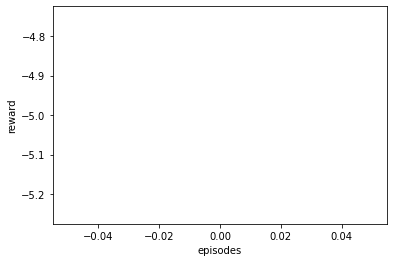

In [7]:
from tqdm import tqdm
from time import sleep
# load model
env = gym.make(env_id)



len_obs_space = env.observation_space.shape[0]
n_actions = env.action_space.n


epsilon = 0
hidden_layer_size = 64
layer_sizes = [len_obs_space, hidden_layer_size, n_actions]
q_hat = DQN(lr=learning_rate, layer_sizes=layer_sizes, device=device).to(device)

# set config file for agent
config = {
    'lr': learning_rate,
    'gamma': gamma,
    'epsilon': epsilon,
    'action_table': action_table,
    't_max': None,
    'max_score': None,
    'episode_printer': 100,
    'env': env,
    'q_hat': q_hat,
    'batch_size': MINI_BATCH_SIZE,
    'exp_mem_size': MEMORY_SIZE,
    'TARGET_UPDATE': TARGET_UPDATE,
    'epsilon_decay': decay_model
}
agent = DQNAgent(config)

PATH = './models/model_0.001_0.99.pt'
agent.load_q_model(PATH)

reward_arr = []
eps = 1
for i in tqdm(range(eps)):
    obs, done, rew = env.reset(), False, 0
    while not done:
        A = agent.get_action(obs)
        act = agent.action_table[A.item()]
        obs, reward, done, info = env.step(act)
        rew += reward
        # sleep(0.01)
        env.render()

    reward_arr.append(rew)
env.close()
print("average reward per episode :", sum(reward_arr) / len(reward_arr))

import numpy as np
import matplotlib.pyplot as plt

rewards = np.array(reward_arr)
plt.plot(rewards)
plt.xlabel('episodes')
plt.ylabel('reward')
print('average reward per episode= {}'.format(np.mean(rewards)))
plt.show()